In [4]:
import bz2
import dill
import matplotlib.pyplot as plt
import numpy as np
import glob, os
import pickle
import ipywidgets as widgets
from ipywidgets import Button, Layout, Dropdown
from lmfit import Model, Parameters
from lmfit.models import PseudoVoigtModel, PolynomialModel, ConstantModel, LinearModel, VoigtModel, GaussianModel
from scipy.interpolate import CubicSpline, splev, splrep
%matplotlib notebook

import inflect
p = inflect.engine()

from xrd_tools import getReflections
from Testing_LMFIT_functions import *

In [5]:
# Generate frames list

# Define paths
data_dir = r'Z:\Diamond_MG28894-1_DATA_BACKUP\rawdata'
cal_dir = r"Z:\Diamond_MG28894-1_DATA_BACKUP\processing"
stacked_data = r"Z:\Diamond_MG28894-1_PROCESSING\Diamond_stacked_data"

scanID = str(108800)

In [ ]:
# with open('Diamond_experiments.pkl', 'rb') as f:
#     Samples = pickle.load(f)
    
# experiment_scanIDs = sorted([str(value[0]) for value in Samples.values() if value[0] != None])

# drop_down = Dropdown(options=experiment_scanIDs, value=experiment_scanIDs[0], description='scanID:', disabled=False, 
#                              layout=Layout(width='40%'), style={'description_width': 'initial'})

# def dropdown_handler(change):
#     global scanID
#     scanID = change.new
# drop_down.observe(dropdown_handler, names='value')
# display(drop_down)

x_max:  3644 	 x_min:  605 	 len_x:  3039 	 len_y:  3039


<IPython.core.display.Javascript object>


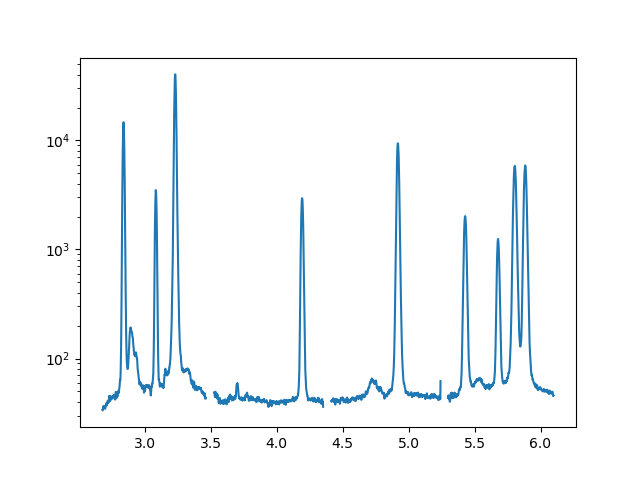

In [6]:
data = np.genfromtxt(stacked_data + "\\0pt8_mask_108800_c9-10-11_compressed.txt").T
data = data[:-3]

### plot diffraction pattern and add horizontal line for each automatically chosen peak & trough
x_min = np.where(data[0][1:]<=2.6815)[0][-1]
x_max = np.where(data[0][1:]>=6.1)[0][0]

x = data[0][x_min:x_max]
y = data[1][x_min:x_max]

print("x_max: ", x_max , "\t x_min: ", x_min, "\t len_x: ", len(x), "\t len_y: ", len(y))
# plt.xlim(2.85, 2.9)
# plt.ylim(5*10**4, 10**5.5)

plt.plot(x, y)
plt.yscale("log")

In [7]:
max_threshold = 500
min_threshold = 80
auto_peaks = list(auto_peak_selector(x, y, max_threshold))
auto_minimums = list(auto_minimum_selector(x, y, min_threshold))

# find maximum for each peak
peak_max = []

for peak in auto_peaks:
    intensitys = [val[1] for val in peak]
    max_y = max(intensitys)
    ymax_twotheta = peak[intensitys.index(max_y)][0]
    peak_max.append((ymax_twotheta, max_y))
    
# find minimum between each peak
trough_mins = []

for peak in auto_minimums:
    intensitys = [val[1] for val in peak]
    min_y = min(intensitys)
    ymin_twotheta = peak[intensitys.index(min_y)][0]
    trough_mins.append((ymin_twotheta, min_y))

print(trough_mins)
    
# remove last minimum where signal is very weak to improve background fit
trough_mins = trough_mins[:-1]

[(2.681188, 33.429392), (3.045688, 45.804667), (3.141313, 53.791689), (3.168313, 70.128307), (3.283063, 77.846953), (3.294313, 74.473824), (3.460813, 43.02831), (3.937813, 35.926782), (4.351813, 36.074688), (4.444063, 37.794926), (5.224813, 41.693731), (5.311438, 40.16781), (5.611813, 52.073987), (5.720938, 58.744636), (6.095563, 45.315454)]


In [9]:
### Overwite knots ###

trough_mins = [(2.683, 34.1), (3.045, 45.4), (3.461, 43.9), (3.592, 38.3), (3.947, 38.8), (4.472, 40.5), (5.222, 43.), (6.038, 49.6)]
trough_mins = [(2.683, 34.1), (3.076, 41), (3.592, 38.3), (3.947, 38.8), (4.472, 40.5), (5.222, 43.), (6.038, 49.6)]

print(trough_mins)

[(2.683, 34.1), (3.076, 41), (3.592, 38.3), (3.947, 38.8), (4.472, 40.5), (5.222, 43.0), (6.038, 49.6)]


[34.1, 41.0, 38.3, 38.8, 40.5, 43.0, 49.6]


<IPython.core.display.Javascript object>


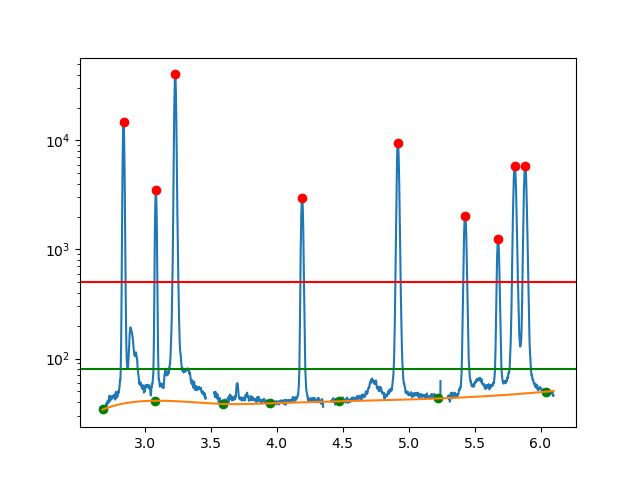

In [10]:
cs = CubicSpline([var[0] for var in trough_mins], [var[1] for var in trough_mins])
bg_knots = cs.__call__([var[0] for var in trough_mins])
print([knot for knot in bg_knots])
bg_params = cs.__call__([var[0] for var in trough_mins])

plt.plot(x, y)
plt.plot([var[0] for var in peak_max], [var[1] for var in peak_max], "ro")
plt.plot([var[0] for var in trough_mins], [var[1] for var in trough_mins], "go")
plt.plot(x, cs(x))
plt.yscale("log")
# plt.xlim(6.075,6.2)
plt.axhline(max_threshold, c="r")
plt.axhline(min_threshold, c="g")
plt.show()

In [ ]:
def bg_spline(x, _0, _1, _2, _3, _4, _5, _6):
    cs = CubicSpline([var[0] for var in trough_mins], [_0, _1, _2, _3, _4, _5, _6])
    return cs(x)

bg_model = Model(bg_spline, prefix="bg")

# set initial background spline parameter values
params = bg_model.make_params(bg_0=34.1, bg_1=41.0, bg_2=38.3, bg_3=38.8, bg_4=40.5, bg_5=43.0, bg_6=49.6)

In [ ]:
for param in params:
    params[param].set(vary=False, min=30)

print(f'parameter names: {bg_model.param_names}')
print(f'independent variables: {bg_model.independent_vars}')

In [5]:
bg_model = ConstantModel(prefix='bg_')
params = bg_model.make_params()
params["bg_c"].set(value=y[0], vary=True, max=y[0])

In [6]:
### parameters for Zr peaks ###

### Zr-Hydride parameters for reverse fit ###
# ZrH111d_min = 2.825; ZrH111d_max = 2.865
# ZrH111g_min = 2.868; ZrH111g_max = 2.89
# ZrH200d_min = 3.271; ZrH200d_max = 3.328
# ZrH200g_min = 3.342; ZrH200g_max = 3.382
# SPP1_min = 3.622 ;SPP1_max = 3.650
# SPP2_min = 3.692; SPP2_max = 3.722
# ZrH220a_min = 4.588; ZrH220a_max = 4.656
# ZrH220b_min = 4.557; ZrH220b_max = 4.595
# ZrH311_min = 5.456; ZrH311_max = 5.495

### Zr-Hydride parameters for forward fit ###
ZrH111d_min = 2.878; ZrH111d_max = 2.915
ZrH111g_min = 2.914; ZrH111g_max = 2.947
ZrH200d_min = 3.306; ZrH200d_max = 3.342; ZrH200d_centre = 3.322
ZrH200g_min = 3.408; ZrH200g_max = 3.428
SPP1_min = 3.692 ;SPP1_max = 3.710
SPP2_min = 3.765; SPP2_max = 3.781
ZrH220a_min = 4.696; ZrH220a_max = 4.749
ZrH220b_min = 4.765; ZrH220b_max = 4.811
ZrH311_min = 5.508; ZrH311_max = 5.549
ZrFeCr_min = 3.15; ZrFeCr_max = 3.17

#########################################################################################

pv_models = {}
# min_y = min(y[50: -50])

for i, maxima in enumerate(auto_peaks):
    
    # generate PseudoVoigtModels for each peak (i.e. maxima range from auto_peak_selector)
    model_key = "pv{0}".format(i+1)
    prefix=model_key+"_"
    pv_models[model_key] = PseudoVoigtModel(prefix=prefix)
    params.update(pv_models[model_key].make_params())
    
    # set initial parameter values
    intensitys = [val[1] for val in maxima]
    max_y = max(intensitys)
    ymax_twotheta = maxima[intensitys.index(max_y)][0]
#     pv_twotheta_max = maxima[-1][0] # set sigma based on min & max ttheta from the auto_peaks function
#     pv_twotheta_min = maxima[0][0]
#     sigma = (pv_twotheta_max-pv_twotheta_min)/4

    sigma = 0.01 # set sigma to known approximate value

    params.add(f"{model_key}_center", value=ymax_twotheta, min=ymax_twotheta-sigma, max=ymax_twotheta+sigma)
    params.add(f"{model_key}_sigma", value=sigma, min=sigma/10, max=sigma*2)
    params.add(f"{model_key}_fraction", value=0.1, min=0.01, max=0.2)

### Add Zr peaks to Zr Model ###
Zr_model = bg_model
for key, value in pv_models.items():
    Zr_model = Zr_model + value

### Fit Zr model ###
zr_init = Zr_model.eval(params, x=x)
zr_out = Zr_model.fit(y, params, x=x, nan_policy='omit')
zr_comps = zr_out.eval_components(x=x)

In [7]:
print(zr_out.fit_report())

[[Model]]
    (((((((((Model(constant, prefix='bg_') + Model(pvoigt, prefix='pv1_')) + Model(pvoigt, prefix='pv2_')) + Model(pvoigt, prefix='pv3_')) + Model(pvoigt, prefix='pv4_')) + Model(pvoigt, prefix='pv5_')) + Model(pvoigt, prefix='pv6_')) + Model(pvoigt, prefix='pv7_')) + Model(pvoigt, prefix='pv8_')) + Model(pvoigt, prefix='pv9_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 806
    # data points      = 2875
    # variables        = 37
    chi-square         = 9884403.34
    reduced chi-square = 3482.87644
    Akaike info crit   = 23484.1495
    Bayesian info crit = 23704.8104
##  Warning: uncertainties could not be estimated:
    bg_c:           at initial value
    bg_c:           at boundary
    pv6_center:     at initial value
    pv7_center:     at initial value
[[Variables]]
    bg_c:           33.7625990 (init = 33.7626)
    pv1_amplitude:  206.371984 (init = 1)
    pv1_center:     2.83918223 (init = 2.839813)
    pv1_sigma:      0.0063877

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
bg_c              33.76     -inf    33.76     None     True     None     None
pv1_amplitude     206.4     -inf      inf     None     True     None     None
pv1_center        2.839     2.83     2.85     None     True     None     None
pv1_fraction    0.08036     0.01      0.2     None     True     None     None
pv1_fwhm        0.01278     -inf      inf     None    False 2.0000000*pv1_sigma     None
pv1_height     1.478e+04     -inf      inf     None    False (((1-pv1_fraction)*pv1_amplitude)/max(1e-15, (pv1_sigma*sqrt(pi/log(2))))+(pv1_fraction*pv1_amplitude)/max(1e-15, (pi*pv1_sigma)))     None
pv1_sigma      0.006388    0.001     0.02     None     True     None     None
pv2_amplitude     49.52     -inf      inf     None     True     None     None
pv2_center        3.084    3.074    3.094     None     True     None     None
pv2_fraction    0.02587     0.01      0.2     None     True     None     None
pv2_fw

<IPython.core.display.Javascript object>


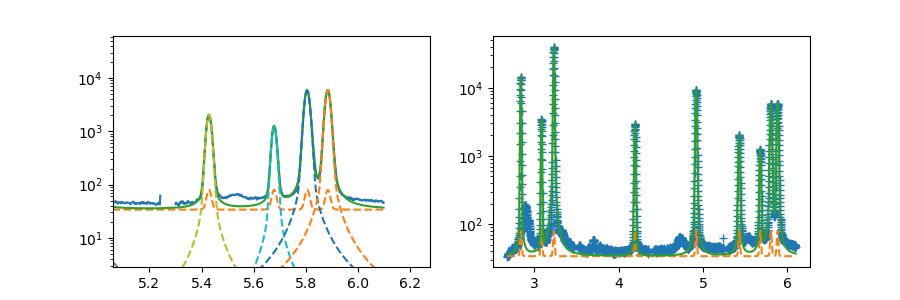

In [8]:
print(zr_out.params.pretty_print())
interactive_plot_results(x, y, zr_init, zr_out)

In [9]:
### fix background & Zr peak parameters ###
zr_params = zr_out.params
for param in zr_params:
    zr_params[param].set(vary=False)

############################################################################################
### setup new parameters file and add Zr-Hydrides (and SPP's)###
zrh_params = zr_params

ZrH_111d = PseudoVoigtModel(prefix='ZrH111d_')
zrh_params.update(ZrH_111d.make_params())
zrh_params['ZrH111d_center'].set(value=ZrH111d_min+(ZrH111d_max-ZrH111d_min)/2, min=ZrH111d_min, max=ZrH111d_max)
zrh_params["ZrH111d_sigma"].set(value = (ZrH111d_max-ZrH111d_min)/4, max=(ZrH111d_max-ZrH111d_min), min=(ZrH111d_max-ZrH111d_min)/10)
zrh_params['ZrH111d_amplitude'].set(min=0)
zrh_params["ZrH111d_fraction"].set(min=0.3, max=0.6)

ZrH_111g = PseudoVoigtModel(prefix='ZrH111g_')
zrh_params.update(ZrH_111g.make_params())
zrh_params['ZrH111g_center'].set(value=ZrH111g_min+(ZrH111g_max-ZrH111g_min)/2, min=ZrH111g_min, max=ZrH111g_max)
zrh_params["ZrH111g_sigma"].set(value = (ZrH111g_max-ZrH111g_min)/4, max=(ZrH111g_max-ZrH111g_min), min=(ZrH111g_max-ZrH111g_min)/10)
zrh_params['ZrH111g_amplitude'].set(min=0)
zrh_params["ZrH111g_fraction"].set(min=0.3, max=0.6)

ZrH_200d = PseudoVoigtModel(prefix='ZrH200d_')
zrh_params.update(ZrH_200d.make_params())
zrh_params['ZrH200d_center'].set(value=ZrH200d_min+(ZrH200d_max-ZrH200d_min)/2, min=ZrH200d_min, max=ZrH200d_max)
zrh_params["ZrH200d_sigma"].set(value = (ZrH200d_max-ZrH200d_min)/4, max=(ZrH200d_max-ZrH200d_min)/2, min=(ZrH200d_max-ZrH200d_min)/10)
zrh_params['ZrH200d_amplitude'].set(min=0)
zrh_params["ZrH200d_fraction"].set(min=0.3, max=0.6)

# ZrH_200g = PseudoVoigtModel(prefix='ZrH200g_')
# zrh_params.update(ZrH_200g.make_params())
# zrh_params['ZrH200g_center'].set(value=ZrH200g_min+(ZrH200g_max-ZrH200g_min)/2, min=ZrH200g_min, max=ZrH200g_max)
# zrh_params["ZrH200g_sigma"].set(value = (ZrH200g_max-ZrH200g_min)/4, max=(ZrH200g_max-ZrH200g_min)/2, min=(ZrH200g_max-ZrH200g_min)/10)
# zrh_params['ZrH200g_amplitude'].set(min=0)
# zrh_params["ZrH200g_fraction"].set(min=0.3, max=0.6)

ZrH_220d = PseudoVoigtModel(prefix='ZrH220d_')
zrh_params.update(ZrH_220d.make_params())
zrh_params['ZrH220d_center'].set(value=ZrH220a_min+(ZrH220a_max-ZrH220a_min)/2, min=ZrH220a_min, max=ZrH220a_max)
zrh_params["ZrH220d_sigma"].set(value = (ZrH220a_max-ZrH220a_min)/4, max=(ZrH220a_max-ZrH220a_min), min=(ZrH220a_max-ZrH220a_min)/10)
zrh_params['ZrH220d_amplitude'].set(min=0)
zrh_params["ZrH220d_fraction"].set(min=0.3, max=0.6)

ZrH_220g = PseudoVoigtModel(prefix='ZrH_220g_')
zrh_params.update(ZrH_220g.make_params())
zrh_params['ZrH_220g_center'].set(value=ZrH220b_min+(ZrH220b_max-ZrH220b_min)/2, min=ZrH220b_min, max=ZrH220b_max)
zrh_params["ZrH_220g_sigma"].set(value = (ZrH220b_max-ZrH220b_min)/4, max=(ZrH220b_max-ZrH220b_min), min=(ZrH220b_max-ZrH220b_min)/10)
zrh_params['ZrH_220g_amplitude'].set(min=0)
zrh_params["ZrH_220g_fraction"].set(min=0.3, max=0.6)

ZrH_311 = PseudoVoigtModel(prefix='ZrH311_')
zrh_params.update(ZrH_311.make_params())
zrh_params['ZrH311_center'].set(value=ZrH311_min+(ZrH311_max-ZrH311_min)/2, min=ZrH311_min, max=ZrH311_max)
zrh_params["ZrH311_sigma"].set(value = (ZrH311_max-ZrH311_min)/4, max=(ZrH311_max-ZrH311_min), min=(ZrH311_max-ZrH311_min)/10)
zrh_params['ZrH311_amplitude'].set(min=0)
zrh_params["ZrH311_fraction"].set(min=0.3, max=0.6)

SPP1 = PseudoVoigtModel(prefix='SPP1_')
zrh_params.update(SPP1.make_params())
zrh_params['SPP1_center'].set(value=SPP1_min+(SPP1_max-SPP1_min)/2, min=SPP1_min, max=SPP1_max)
zrh_params["SPP1_sigma"].set(value = (SPP1_max-SPP1_min)/4, max=(SPP1_max-SPP1_min), min=(SPP1_max-SPP1_min)/10)
zrh_params['SPP1_amplitude'].set(min=0)
zrh_params["SPP1_fraction"].set(min=0.3, max=0.8)

SPP2 = PseudoVoigtModel(prefix='SPP2_')
zrh_params.update(SPP2.make_params())
zrh_params['SPP2_center'].set(value=SPP2_min+(SPP2_max-SPP2_min)/2, min=SPP2_min, max=SPP2_max)
zrh_params["SPP2_sigma"].set(value=(SPP2_max-SPP2_min)/4, max=(SPP2_max-SPP2_min), min=(SPP2_max-SPP2_min)/10)
zrh_params['SPP2_amplitude'].set(min=0)
zrh_params["SPP2_fraction"].set(min=0.3, max=0.8)

ZrFeCr = PseudoVoigtModel(prefix='ZrFeCr_')
zrh_params.update(ZrFeCr.make_params())
zrh_params['ZrFeCr_center'].set(value=ZrFeCr_min+(ZrFeCr_max-ZrFeCr_min)/2, min=ZrFeCr_min, max=ZrFeCr_max)
zrh_params["ZrFeCr_sigma"].set(value=(ZrFeCr_max-ZrFeCr_min)/4, max=(ZrFeCr_max-ZrFeCr_min), min=(ZrFeCr_max-ZrFeCr_min)/10)
zrh_params['ZrFeCr_amplitude'].set(min=0)
zrh_params["ZrFeCr_fraction"].set(min=0.3, max=0.8)

# ###########################################################################################

### make composite model with background & Zr peak parameteres fixed ###
comp_model = Zr_model + ZrH_111d + ZrH_111g + ZrFeCr + ZrH_200d + SPP1 + SPP2 + ZrH_220d + ZrH_220g + ZrH_311 # + ZrH_200g
# comp_model = Zr_model + ZrH_111d + ZrH_111g + ZrFeCr + ZrH_200d


### rough fit for hydride peaks ###
comp_init = comp_model.eval(zrh_params, x=x)
comp_out = comp_model.fit(y, zrh_params, x=x, nan_policy='omit')
comp_comps = comp_out.eval_components(x=x)

In [10]:
print(comp_out.fit_report())

[[Model]]
    ((((((((((((((((((Model(constant, prefix='bg_') + Model(pvoigt, prefix='pv1_')) + Model(pvoigt, prefix='pv2_')) + Model(pvoigt, prefix='pv3_')) + Model(pvoigt, prefix='pv4_')) + Model(pvoigt, prefix='pv5_')) + Model(pvoigt, prefix='pv6_')) + Model(pvoigt, prefix='pv7_')) + Model(pvoigt, prefix='pv8_')) + Model(pvoigt, prefix='pv9_')) + Model(pvoigt, prefix='ZrH111d_')) + Model(pvoigt, prefix='ZrH111g_')) + Model(pvoigt, prefix='ZrFeCr_')) + Model(pvoigt, prefix='ZrH200d_')) + Model(pvoigt, prefix='SPP1_')) + Model(pvoigt, prefix='SPP2_')) + Model(pvoigt, prefix='ZrH220d_')) + Model(pvoigt, prefix='ZrH_220g_')) + Model(pvoigt, prefix='ZrH311_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 4119
    # data points      = 2875
    # variables        = 36
    chi-square         = 9159871.32
    reduced chi-square = 3226.44287
    Akaike info crit   = 23263.2874
    Bayesian info crit = 23477.9844
##  Warning: uncertainties could not be estimated

Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
SPP1_amplitude         1.074        0      inf     None     True     None     None
SPP1_center              3.7    3.692     3.71     None     True     None     None
SPP1_fraction            0.8      0.3      0.8     None     True     None     None
SPP1_fwhm            0.03587     -inf      inf     None    False 2.0000000*SPP1_sigma     None
SPP1_height            20.87     -inf      inf     None    False (((1-SPP1_fraction)*SPP1_amplitude)/max(1e-15, (SPP1_sigma*sqrt(pi/log(2))))+(SPP1_fraction*SPP1_amplitude)/max(1e-15, (pi*SPP1_sigma)))     None
SPP1_sigma           0.01793   0.0018    0.018     None     True     None     None
SPP2_amplitude        0.6611        0      inf     None     True     None     None
SPP2_center            3.776    3.765    3.781     None     True     None     None
SPP2_fraction            0.8      0.3      0.8     None     True     None     None
SPP2_fwhm            0.03199

<IPython.core.display.Javascript object>


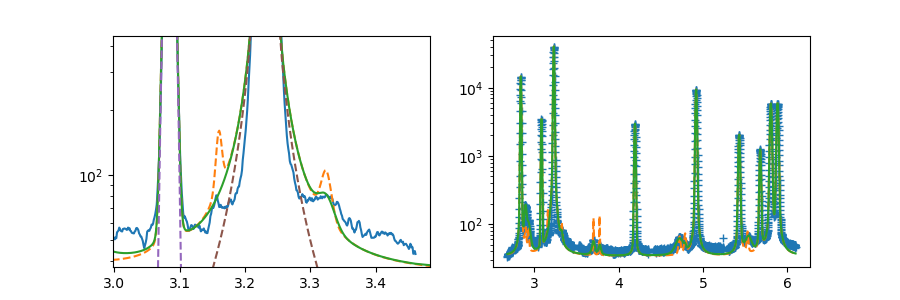

In [11]:
print(comp_out.params.pretty_print())
interactive_plot_results(x, y, comp_init, comp_out)

In [19]:
### set all parameters to vary ####
params_free = comp_out.params
for param in params_free:
    params_free[param].set(vary=False)

#     if "pv" in param:
#         params_free[param].set(vary=True)
#     if "ZrH" in param:
#         params_free[param].set(vary=False)

for param in params_free:
#     if "pv2" in param:
#         params_free[param].set(vary=True)
    if "pv3" in param:
        params_free[param].set(vary=True)
    if "ZrH200d_" in param:
        params_free[param].set(vary=True)
    if "ZrFeCr_" in param:
        params_free[param].set(vary=True)
    if "bg_" in param:
        params_free[param].set(vary=True)

params_free["pv3_fraction"].set(vary=True, max=0.2)
params_free["pv3_sigma"].set(vary=True, max=0.005)
        
        
### get the bloody 10-11 to fit better!
final_init = comp_model.eval(params_free, x=x)
final_out = comp_model.fit(y, params_free, x=x, nan_policy='omit')
final_comps = final_out.eval_components(x=x)

In [20]:
print(final_out.fit_report())

[[Model]]
    ((((((((((((((((((Model(constant, prefix='bg_') + Model(pvoigt, prefix='pv1_')) + Model(pvoigt, prefix='pv2_')) + Model(pvoigt, prefix='pv3_')) + Model(pvoigt, prefix='pv4_')) + Model(pvoigt, prefix='pv5_')) + Model(pvoigt, prefix='pv6_')) + Model(pvoigt, prefix='pv7_')) + Model(pvoigt, prefix='pv8_')) + Model(pvoigt, prefix='pv9_')) + Model(pvoigt, prefix='ZrH111d_')) + Model(pvoigt, prefix='ZrH111g_')) + Model(pvoigt, prefix='ZrFeCr_')) + Model(pvoigt, prefix='ZrH200d_')) + Model(pvoigt, prefix='SPP1_')) + Model(pvoigt, prefix='SPP2_')) + Model(pvoigt, prefix='ZrH220d_')) + Model(pvoigt, prefix='ZrH_220g_')) + Model(pvoigt, prefix='ZrH311_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 2875
    # variables        = 19
    chi-square         = 1.5654e+09
    reduced chi-square = 548121.632
    Akaike info crit   = 38009.9129
    Bayesian info crit = 38123.2252
##  Warning: uncertainties could not be estimated:


Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
SPP1_amplitude         1.074        0      inf     None    False     None     None
SPP1_center              3.7    3.692     3.71     None    False     None     None
SPP1_fraction            0.8      0.3      0.8     None    False     None     None
SPP1_fwhm            0.03587     -inf      inf     None    False 2.0000000*SPP1_sigma     None
SPP1_height            20.87     -inf      inf     None    False (((1-SPP1_fraction)*SPP1_amplitude)/max(1e-15, (SPP1_sigma*sqrt(pi/log(2))))+(SPP1_fraction*SPP1_amplitude)/max(1e-15, (pi*SPP1_sigma)))     None
SPP1_sigma           0.01793   0.0018    0.018     None    False     None     None
SPP2_amplitude        0.6611        0      inf     None    False     None     None
SPP2_center            3.776    3.765    3.781     None    False     None     None
SPP2_fraction            0.8      0.3      0.8     None    False     None     None
SPP2_fwhm            0.03199

<IPython.core.display.Javascript object>


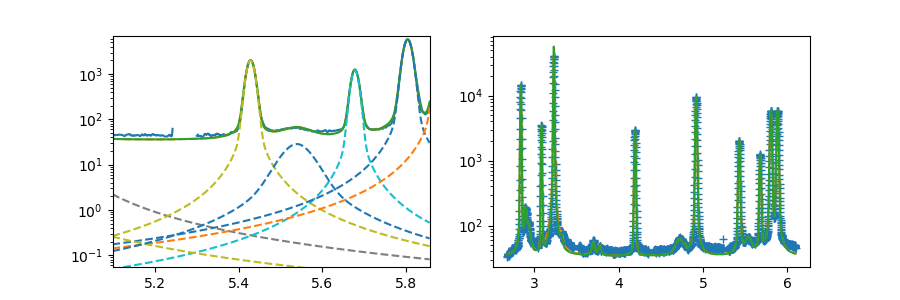

In [21]:
print(final_out.params.pretty_print())
interactive_plot_results(x, y, final_init, final_out)

In [ ]:
params_free['ZrH111d_amplitude'].set(min=1)
params_free['ZrH111g_amplitude'].set(min=1)
params_free['ZrH200d_amplitude'].set(min=0.25)
# params_free['ZrH200g_amplitude'].set(min=100)
# params_free['ZrH220d_amplitude'].set(min=1)
# params_free['ZrH_220g_amplitude'].set(min=1)
params_free['ZrH311_amplitude'].set(min=1)
params_free["ZrFeCr_amplitude"].set(min=0.25)
# params_free["ZrH111d_fraction"].set(min=0.2, max=1)
# params_free["ZrH111g_fraction"].set(min=0.2, max=1)
# params_free["ZrH200d_fraction"].set(min=0.2, max=1)
# # params_free["ZrH200g_fraction"].set(min=0.2, max=1)
# params_free["ZrH220d_fraction"].set(min=0.2, max=1)
# params_free["ZrH_220g_fraction"].set(min=0.2, max=1)
# params_free["ZrH311_fraction"].set(min=0.2, max=1)
# params_free["ZrFeCr_fraction"].set(min=0.2, max=1)

### do final fit
final_init = comp_model.eval(params_free, x=x)
final_out = comp_model.fit(y, params_free, x=x, nan_policy='omit')
final_comps = final_out.eval_components(x=x)

In [ ]:
print(zr_out.fit_report(), "\n", final_out.fit_report(), "\n", comp_out.fit_report())

In [ ]:
print(final_out.params.pretty_print())
interactive_plot_results(x, y, final_init, final_out)

## Loop through full experiment

In [22]:
fits = dict()
fits["1"] = [final_out, final_comps, final_out.params]

In [23]:
frames = [int(i) for i in data.T[0][1:]]
frames

[1,
 37,
 73,
 109,
 145,
 181,
 217,
 253,
 289,
 325,
 361,
 397,
 433,
 469,
 505,
 541,
 577]

fitting frame:  37 	 index:  2


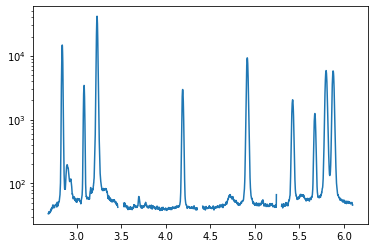

Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
SPP1_amplitude         1.643        0      inf     None     True     None     None
SPP1_center            3.699    3.692     3.71     None     True     None     None
SPP1_fraction         0.3169      0.3      0.8     None     True     None     None
SPP1_fwhm            0.03587     -inf      inf     None     True     None     None
SPP1_height            20.87     -inf      inf     None     True     None     None
SPP1_sigma           0.01718   0.0018    0.018     None     True     None     None
SPP2_amplitude        0.5475        0      inf     None     True     None     None
SPP2_center            3.775    3.765    3.781     None     True     None     None
SPP2_fraction         0.5448      0.3      0.8     None     True     None     None
SPP2_fwhm            0.03199     -inf      inf     None     True     None     None
SPP2_height            14.41     -inf      inf     None     True     None     None
SP

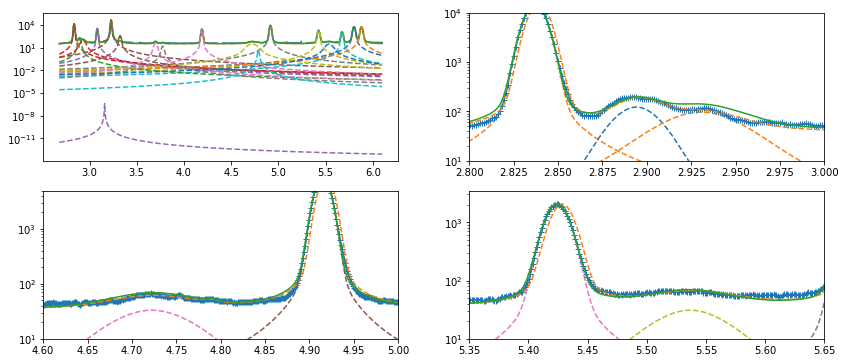

pv1_center Increment =  -2.14e-03 Min =  2.83e+00 Max =  2.85e+00
pv2_center Increment =  -2.35e-03 Min =  3.07e+00 Max =  3.09e+00
pv3_center Increment =  -2.39e-03 Min =  3.22e+00 Max =  3.24e+00
pv4_center Increment =  -3.32e-03 Min =  4.18e+00 Max =  4.20e+00
pv5_center Increment =  -3.77e-03 Min =  4.91e+00 Max =  4.93e+00
pv6_center Increment =  -4.27e-03 Min =  5.42e+00 Max =  5.44e+00
pv7_center Increment =  -4.47e-03 Min =  5.67e+00 Max =  5.69e+00
pv8_center Increment =  -4.59e-03 Min =  5.80e+00 Max =  5.82e+00
pv9_center Increment =  -4.70e-03 Min =  5.87e+00 Max =  5.89e+00
ZrH111d_center Increment =  -1.10e-03 Min =  2.88e+00 Max =  2.92e+00
Warning - likelyhood of poor fit for ZrH111g_center
ZrH111g_center Increment =  1.00e-03 Min =  2.91e+00 Max =  2.95e+00
ZrH111g_center Increment =  1.00e-03 Min =  2.92e+00 Max =  2.95e+00
Warning - likelyhood of poor fit for ZrH200d_center
ZrH200d_center Increment =  1.00e-03 Min =  3.31e+00 Max =  3.34e+00
ZrH200d_center Increment 

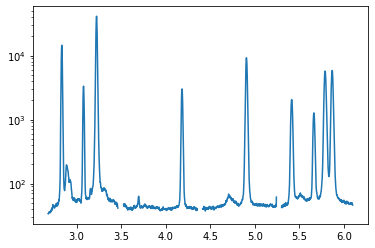

Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
SPP1_amplitude         1.324        0      inf     None     True     None     None
SPP1_center            3.693    3.691    3.709     None     True     None     None
SPP1_fraction            0.8      0.3      0.8     None     True     None     None
SPP1_fwhm            0.03587     -inf      inf     None     True     None     None
SPP1_height            20.87     -inf      inf     None     True     None     None
SPP1_sigma             0.018   0.0018    0.018     None     True     None     None
SPP2_amplitude        0.7559        0      inf     None     True     None     None
SPP2_center            3.771    3.765    3.781     None     True     None     None
SPP2_fraction            0.8      0.3      0.8     None     True     None     None
SPP2_fwhm            0.03199     -inf      inf     None     True     None     None
SPP2_height            14.41     -inf      inf     None     True     None     None
SP

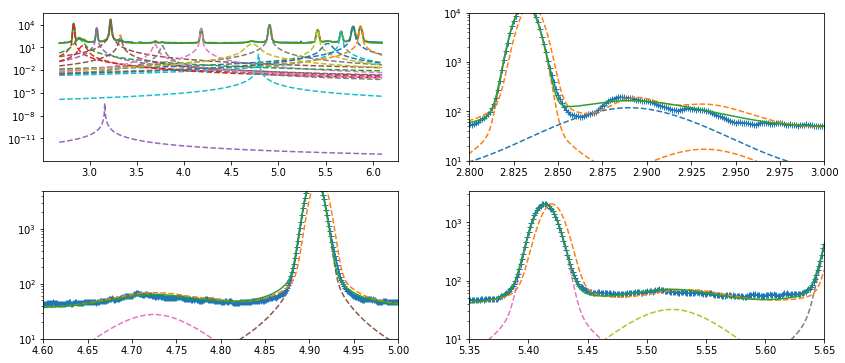

pv1_center Increment =  -3.16e-03 Min =  2.83e+00 Max =  2.85e+00
pv2_center Increment =  -3.54e-03 Min =  3.07e+00 Max =  3.09e+00
pv3_center Increment =  -3.91e-03 Min =  3.22e+00 Max =  3.24e+00
pv4_center Increment =  -4.33e-03 Min =  4.18e+00 Max =  4.20e+00
pv5_center Increment =  -5.44e-03 Min =  4.91e+00 Max =  4.93e+00
pv6_center Increment =  -5.77e-03 Min =  5.41e+00 Max =  5.43e+00
pv7_center Increment =  -5.50e-03 Min =  5.66e+00 Max =  5.68e+00
pv8_center Increment =  -4.65e-03 Min =  5.79e+00 Max =  5.81e+00
pv9_center Increment =  -5.10e-03 Min =  5.87e+00 Max =  5.89e+00
ZrH111d_center Increment =  -2.75e-03 Min =  2.88e+00 Max =  2.91e+00
Warning - likelyhood of poor fit for ZrH111g_center
ZrH111g_center Increment =  1.00e-03 Min =  2.92e+00 Max =  2.95e+00
ZrH111g_center Increment =  1.00e-03 Min =  2.92e+00 Max =  2.95e+00
Warning - likelyhood of poor fit for ZrH200d_center
ZrH200d_center Increment =  1.00e-03 Min =  3.31e+00 Max =  3.34e+00
ZrH200d_center Increment 

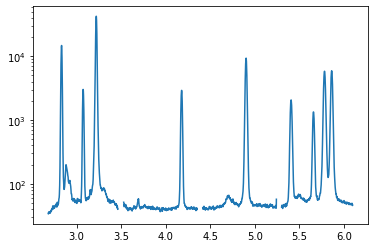

Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
SPP1_amplitude         1.324        0      inf     None     True     None     None
SPP1_center            3.688    3.686    3.704     None     True     None     None
SPP1_fraction            0.8      0.3      0.8     None     True     None     None
SPP1_fwhm            0.03587     -inf      inf     None     True     None     None
SPP1_height            20.87     -inf      inf     None     True     None     None
SPP1_sigma             0.018   0.0018    0.018     None     True     None     None
SPP2_amplitude        0.7559        0      inf     None     True     None     None
SPP2_center            3.767    3.761    3.777     None     True     None     None
SPP2_fraction            0.8      0.3      0.8     None     True     None     None
SPP2_fwhm            0.03199     -inf      inf     None     True     None     None
SPP2_height            14.41     -inf      inf     None     True     None     None
SP

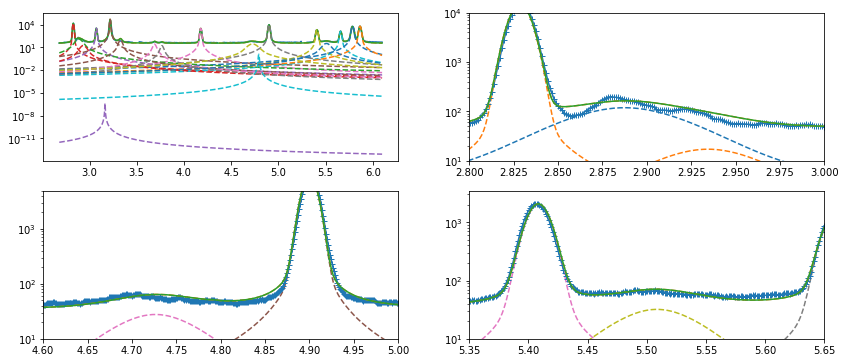

Warning - likelyhood of poor fit for pv1_center
pv1_center Increment =  1.00e-03 Min =  2.82e+00 Max =  2.84e+00
pv1_center Increment =  1.00e-03 Min =  2.83e+00 Max =  2.85e+00
Warning - likelyhood of poor fit for pv2_center
pv2_center Increment =  1.00e-03 Min =  3.07e+00 Max =  3.09e+00
pv2_center Increment =  1.00e-03 Min =  3.07e+00 Max =  3.09e+00
Warning - likelyhood of poor fit for pv3_center
pv3_center Increment =  1.00e-03 Min =  3.22e+00 Max =  3.24e+00
pv3_center Increment =  1.00e-03 Min =  3.22e+00 Max =  3.24e+00
Warning - likelyhood of poor fit for pv4_center
pv4_center Increment =  1.00e-03 Min =  4.17e+00 Max =  4.19e+00
pv4_center Increment =  1.00e-03 Min =  4.18e+00 Max =  4.20e+00
Warning - likelyhood of poor fit for pv5_center
pv5_center Increment =  1.00e-03 Min =  4.90e+00 Max =  4.92e+00
pv5_center Increment =  1.00e-03 Min =  4.90e+00 Max =  4.92e+00
Warning - likelyhood of poor fit for pv6_center
pv6_center Increment =  1.00e-03 Min =  5.41e+00 Max =  5.43e+

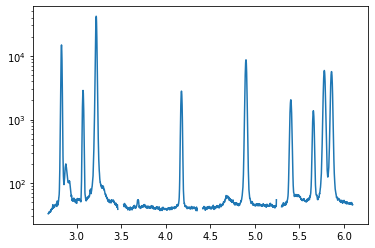

Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
SPP1_amplitude         1.324        0      inf     None     True     None     None
SPP1_center             3.69    3.688    3.706     None     True     None     None
SPP1_fraction            0.8      0.3      0.8     None     True     None     None
SPP1_fwhm            0.03587     -inf      inf     None     True     None     None
SPP1_height            20.87     -inf      inf     None     True     None     None
SPP1_sigma             0.018   0.0018    0.018     None     True     None     None
SPP2_amplitude        0.7559        0      inf     None     True     None     None
SPP2_center            3.769    3.763    3.779     None     True     None     None
SPP2_fraction            0.8      0.3      0.8     None     True     None     None
SPP2_fwhm            0.03199     -inf      inf     None     True     None     None
SPP2_height            14.41     -inf      inf     None     True     None     None
SP

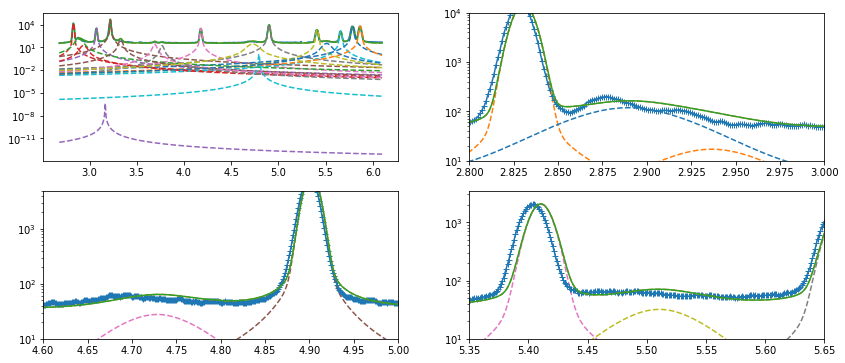

Warning - likelyhood of poor fit for pv1_center
pv1_center Increment =  1.00e-03 Min =  2.83e+00 Max =  2.85e+00
pv1_center Increment =  1.00e-03 Min =  2.83e+00 Max =  2.85e+00
Warning - likelyhood of poor fit for pv2_center
pv2_center Increment =  1.00e-03 Min =  3.07e+00 Max =  3.09e+00
pv2_center Increment =  1.00e-03 Min =  3.07e+00 Max =  3.09e+00
Warning - likelyhood of poor fit for pv3_center
pv3_center Increment =  1.00e-03 Min =  3.22e+00 Max =  3.24e+00
pv3_center Increment =  1.00e-03 Min =  3.22e+00 Max =  3.24e+00
Warning - likelyhood of poor fit for pv4_center
pv4_center Increment =  1.00e-03 Min =  4.18e+00 Max =  4.20e+00
pv4_center Increment =  1.00e-03 Min =  4.18e+00 Max =  4.20e+00
Warning - likelyhood of poor fit for pv5_center
pv5_center Increment =  1.00e-03 Min =  4.90e+00 Max =  4.92e+00
pv5_center Increment =  1.00e-03 Min =  4.90e+00 Max =  4.92e+00
Warning - likelyhood of poor fit for pv6_center
pv6_center Increment =  1.00e-03 Min =  5.41e+00 Max =  5.43e+

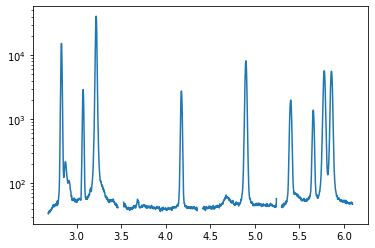

Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
SPP1_amplitude         0.723        0      inf     None     True     None     None
SPP1_center             3.69     3.69    3.708     None     True     None     None
SPP1_fraction          0.784      0.3      0.8     None     True     None     None
SPP1_fwhm            0.03587     -inf      inf     None     True     None     None
SPP1_height            20.87     -inf      inf     None     True     None     None
SPP1_sigma           0.01753   0.0018    0.018     None     True     None     None
SPP2_amplitude        0.4625        0      inf     None     True     None     None
SPP2_center             3.77    3.765    3.781     None     True     None     None
SPP2_fraction         0.3968      0.3      0.8     None     True     None     None
SPP2_fwhm            0.03199     -inf      inf     None     True     None     None
SPP2_height            14.41     -inf      inf     None     True     None     None
SP

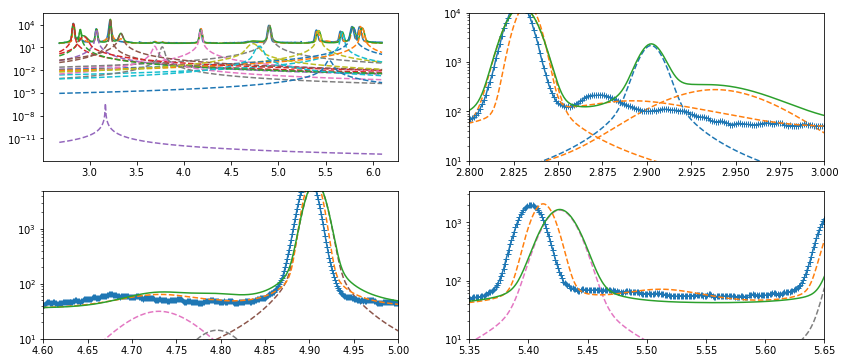

pv1_center Increment =  -3.10e-03 Min =  2.83e+00 Max =  2.85e+00
pv2_center Increment =  -3.01e-03 Min =  3.07e+00 Max =  3.09e+00
pv3_center Increment =  -1.97e-03 Min =  3.22e+00 Max =  3.24e+00
pv4_center Increment =  -3.09e-03 Min =  4.18e+00 Max =  4.20e+00
pv5_center Increment =  2.61e-03 Min =  4.90e+00 Max =  4.92e+00
pv6_center Increment =  1.41e-02 Min =  5.41e+00 Max =  5.43e+00
pv7_center Increment =  1.41e-02 Min =  5.66e+00 Max =  5.68e+00
Warning - likelyhood of poor fit for pv8_center
pv8_center Increment =  1.00e-03 Min =  5.79e+00 Max =  5.81e+00
pv8_center Increment =  1.00e-03 Min =  5.79e+00 Max =  5.81e+00
pv9_center Increment =  1.93e-02 Min =  5.87e+00 Max =  5.89e+00
ZrH111d_center Increment =  1.09e-02 Min =  2.88e+00 Max =  2.92e+00
Warning - likelyhood of poor fit for ZrH111g_center
ZrH111g_center Increment =  1.00e-03 Min =  2.92e+00 Max =  2.95e+00
ZrH111g_center Increment =  1.00e-03 Min =  2.92e+00 Max =  2.96e+00
Warning - likelyhood of poor fit for Zr

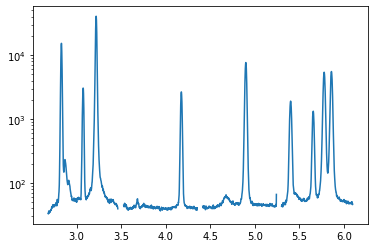

KeyboardInterrupt: 

In [31]:
%matplotlib inline

old_params = final_out.params

### set all parameters to vary ####
for param in old_params:
    old_params[param].set(vary=True)

for i, frame in enumerate(list(frames)[1:]): #  fit from next frame in list
    ### load data and plot 
#     test = stacked_data + "\\" + str(scanID) + "0pt8_mask_108800_c9-10-11_compressed.txt"
    test = stacked_data + "\\" + "0pt8_mask_108800_c9-10-11_compressed.txt"

    data = np.genfromtxt(test).T
    ### remove final three frames as these do not contain data for 108800
    data = data[:-3]

    ### slice ttheta range
    x_min = np.where(data[0][1:]<=2.6815)[0][-1]
    x_max = np.where(data[0][1:]>=6.1)[0][0]

    print("fitting frame: ", frame, "\t index: ", i+2)
    x = data[0][x_min:x_max]
    y = data[i+2][x_min:x_max]
    plt.plot(x, y)
    plt.yscale("log")
    plt.show()

    ### do model ###
    init = comp_model.eval(old_params, x=x)
    out = comp_model.fit(y, old_params, x=x, nan_policy='omit')
    comps = out.eval_components(x=x)
    ### print all parameters ###
    out.params.pretty_print()
    ### plot results ###
    plot_results(x, y, init, out)

    ### update the peak_centre, & min & max boundaries buy peak shift as parameters guess for next fit ###
    for param in out.params.valuesdict().keys():
        if "center" in param:
            ### calc movement of peak centre ### 
            if out.params[param].value == old_params[param].value:
                print("Warning - likelyhood of poor fit for " + param)
                increment = 1*10**-3
                centre_value = out.params[param].value
                centre_min = out.params[param].min
                centre_max = out.params[param].max
                print(param, "Increment = ", f"{increment:.2e}", "Min = ", f"{centre_min:.2e}", "Max = ", f"{centre_max:.2e}")
                ### update the new parameter min & max by increment ###
                out.params[param].set(value= centre_value + increment, min= centre_min + increment, max= centre_max + increment)
        
            if out.params[param].value != old_params[param].value:
                increment = out.params[param].value - old_params[param].value
                centre_value = out.params[param].value
                centre_min = out.params[param].min
                centre_max = out.params[param].max
                print(param, "Increment = ", f"{increment:.2e}", "Min = ", f"{centre_min:.2e}", "Max = ", f"{centre_max:.2e}")
                ### update the new parameter min & max by increment ###
                out.params[param].set(value= centre_value + increment, min= centre_min + increment, max= centre_max + increment)        
                ### check centre is not hitting limits ###
                if centre_value <= centre_min+0.001:
                    print("Warning: ", param, "peak centre has reached lower limit")
                if centre_value >= centre_max+0.001:
                    print("Warning: ", param, "peak centre has reached upper limit")
    #                     out.params[param].set(value= centre_value + increment, min= centre_min + increment, max= centre_max + increment*2)        
                    
    ### update parameters to new parameters
    old_params = out.params
    
    ### add to dictionary ###
    fits[str(frame)] = [out, comps, old_params]
    
%matplotlib notebook

In [ ]:
# ### load data and plot 
# test_frame = 20
# test = "Compressed_data\\" + str(sample_name) + '_compressed\\' + f'{test_frame:05d}' + ".txt"
# print(test)
# dat = np.loadtxt(test)
# x = dat[:, 0]
# y = dat[:, 1]
# plt.plot(x, y)
# plt.yscale("log")
# plt.show()

# ### load previous frame parameters ###
# link_prev = list(fits.keys())[list(fits.keys()).index(str(test_frame))-1]
# print(link_prev)
# params = fits[link_prev][-1]
# ### manually adjust params ###
# params["ZrH2_center"].set(max=2.92, min=2.899)

# ### fit ###
# init = comp_model.eval(params, x=x)
# out = comp_model.fit(y, params, x=x)
# comps = out.eval_components(x=x)
# ### print all parameters ###
# out.params.pretty_print()
# plot_results(x, y, init, out)
# fits[str(test_frame)] = [out, comps, old_params]

In [ ]:
DZrH_111_centers = []
GZrH_111_centers = []

for key, var in fits.items():
    if "ZrH111d_center" in var[0].params:
        DZrH_111_centers.append(var[0].params["ZrH111d_center"].value)
    if "ZrH111g_center" in var[0].params:
        GZrH_111_centers.append(var[0].params["ZrH111g_center"].value)

In [ ]:
DZrH_111_d_centers = [] 

for ttheta in DZrH_111_centers:
    d = 0.141565 / (2*np.sin(np.deg2rad(ttheta)))
    DZrH_111_d_centers.append(d)
    
GZrH_111_d_centers = [] 

for ttheta in GZrH_111_centers:
    d = 0.141565 / (2*np.sin(np.deg2rad(ttheta)))
    GZrH_111_d_centers.append(d)

In [ ]:
D_L0 = DZrH_111_d_centers[-1]
G_L0 = GZrH_111_d_centers[-1]
D_strain = []
G_strain = []

for Dl, Gl in zip(DZrH_111_d_centers, GZrH_111_d_centers):
    D_strain.append((Dl - D_L0) / D_L0)
    G_strain.append((Gl - G_L0) / G_L0)

In [ ]:
print(np.asarray(D_strain)*10**6)
print(np.asarray(G_strain)*10**6)